# Tutorial 1 - Basics of working with satellite data in Python

| updated August 2023


## Objective

This tutorial will show the steps to grab data hosted on an ERDDAP server from Python, how to work with NetCDF files in Python and how to make some maps and time-series of sea surface temperature.


## The tutorial demonstrates the following techniques

- Locating a satellite product in ERDDAP, manually changing the constraints and copying the URL defining the data request
- Downloading the resulting NetCDF file
- Opening and examining the NetCDF file
- Making basic maps and time series plots


## Datasets used

**CoralTemp Sea Surface Temperature** product from the NOAA Coral Reef Watch program.
The NOAA Coral Reef Watch (CRW) daily global 5km Sea Surface Temperature (SST) product, also known as CoralTemp, shows the nighttime ocean temperature measured at the surface. The SST scale ranges from -2 to 35 °C.
The CoralTemp SST data product was developed from two, related reanalysis (reprocessed) SST products and a near real-time SST product. Spanning January 1, 1985 to the present, the CoralTemp SST is one of the best and most internally consistent daily global 5km SST products available.
More information about the product: https://coralreefwatch.noaa.gov/product/5km/index_5km_sst.php

We will use the monthly composite of this product and download it from the NOAA CoastWatch ERDDAP server:
https://coastwatch.pfeg.noaa.gov/erddap/griddap/NOAA_DHW_monthly.graph


### 1. Downlading data from Python

Because ERDDAP includes RESTful services, you can download data listed on any ERDDAP platform from Python using the URL structure. 

For example, the following page allows you to subset monthly sea surface temperature (SST) https://coastwatch.pfeg.noaa.gov/erddap/griddap/NOAA_DHW_monthly.html

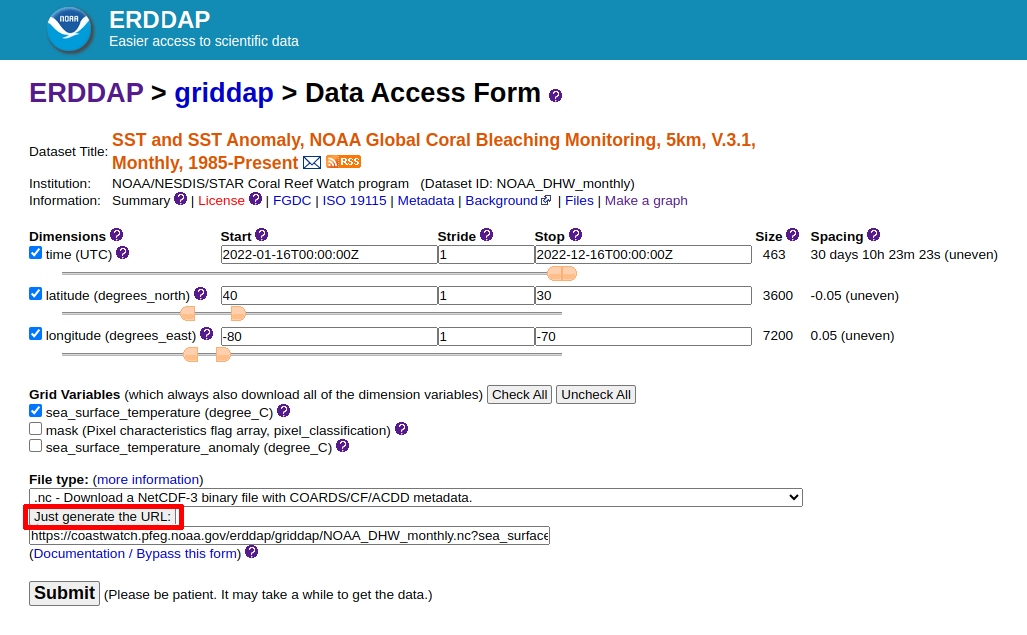
Select your region and date range of interest, then select the '.nc' (NetCDF) file type and click on "Just Generate the URL".

In this specific example, the URL we generated is :
https://coastwatch.pfeg.noaa.gov/erddap/griddap/NOAA_DHW_monthly.nc?sea_surface_temperature%5B(2022-01-16T00:00:00Z):1:(2022-12-16T00:00:00Z)%5D%5B(40):1:(30)%5D%5B(-80):1:(-70)%5D

In Python, run the following to download the data using the generated URL :


In [1]:
import urllib.request
url="https://coastwatch.pfeg.noaa.gov/erddap/griddap/NOAA_DHW_monthly.nc?sea_surface_temperature%5B(2022-01-16T00:00:00Z):1:(2022-12-16T00:00:00Z)%5D%5B(40):1:(30)%5D%5B(-80):1:(-70)%5D"
urllib.request.urlretrieve(url, "sst.nc")

('sst.nc', <http.client.HTTPMessage at 0x7f81bc3c7100>)

### 2. Importing NetCDF4 data in Python

Now that we've downloaded the data locally, we can import it and extract our variables of interest.

The xarray package makes it very convenient to work with NetCDF files. Documentation is available here:
http://xarray.pydata.org/en/stable/why-xarray.html

In [2]:
import xarray as xr
import netCDF4 as nc

- Open the file and load it as an xarray dataset:

In [14]:
ds = xr.open_dataset('sst.nc',decode_cf=True)

- examine the data structure:

In [15]:
ds

<xarray.Dataset>
Dimensions:                  (time: 12, latitude: 202, longitude: 201)
Coordinates:
  * time                     (time) datetime64[ns] 2022-01-16 ... 2022-12-16
  * latitude                 (latitude) float32 40.03 39.97 ... 30.02 29.98
  * longitude                (longitude) float32 -80.02 -79.97 ... -70.07 -70.02
Data variables:
    sea_surface_temperature  (time, latitude, longitude) float32 ...
Attributes: (12/65)
    acknowledgement:                  NOAA Coral Reef Watch program
    cdm_data_type:                    Grid
    comment:                          This is a product of NOAA Coral Reef Wa...
    contributor_name:                 NOAA Coral Reef Watch program
    contributor_role:                 Collecting source data and deriving pro...
    Conventions:                      CF-1.6, ACDD-1.3, COARDS
    ...                               ...
    time_coverage_duration:           P1M
    time_coverage_end:                2022-12-16T00:00:00Z
    time_coverage_resolution:         P1M
    time_coverage_start:              2022-01-16T00:00:00Z
    title:                            SST and SST Anomaly, NOAA Global Coral ...
    Westernmost_Easting:              -80.024994

- examine which coordinates and variables are included in the dataset:

In [16]:
ds.coords

Coordinates:
  * time       (time) datetime64[ns] 2022-01-16 2022-02-16 ... 2022-12-16
  * latitude   (latitude) float32 40.03 39.97 39.93 39.88 ... 30.08 30.02 29.98
  * longitude  (longitude) float32 -80.02 -79.97 -79.92 ... -70.12 -70.07 -70.02

In [17]:
ds.data_vars

Data variables:
    sea_surface_temperature  (time, latitude, longitude) float32 ...

- examine the structure of sea_surface_temperature:

In [18]:
ds.sea_surface_temperature.shape

(12, 202, 201)

Our dataset is a 3-D array with 202 rows corresponding to latitudes and 201 columns corresponding to longitudes,  for each of the 12 time steps.

- get the dates for each time step:

In [19]:
ds.time

<xarray.DataArray 'time' (time: 12)>
array(['2022-01-16T00:00:00.000000000', '2022-02-16T00:00:00.000000000',
       '2022-03-16T00:00:00.000000000', '2022-04-16T00:00:00.000000000',
       '2022-05-16T00:00:00.000000000', '2022-06-16T00:00:00.000000000',
       '2022-07-16T00:00:00.000000000', '2022-08-16T00:00:00.000000000',
       '2022-09-16T00:00:00.000000000', '2022-10-16T00:00:00.000000000',
       '2022-11-16T00:00:00.000000000', '2022-12-16T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-01-16 2022-02-16 ... 2022-12-16
Attributes:
    _CoordinateAxisType:    Time
    actual_range:           [1.6422912e+09 1.6711488e+09]
    axis:                   T
    coverage_content_type:  coordinate
    ioos_category:          Time
    long_name:              reference time of the last day of the composite t...
    standard_name:          time
    time_origin:            01-JAN-1970 00:00:00

### 3. Working with the extracted data

### Creating a map for one time step

Let's create a map of SST for January 2022 (our first time step).

In [20]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
np.warnings.filterwarnings('ignore')

- set some color breaks

In [21]:
np.nanmin(ds.sea_surface_temperature)

2.34

In [22]:
np.nanmax(ds.sea_surface_temperature)

29.87

In [30]:
levs = np.arange(2, 30, 0.05)

- define a color palette

In [24]:
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"]

- set color scale using the jet palette

In [25]:
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))

- plot the SST map

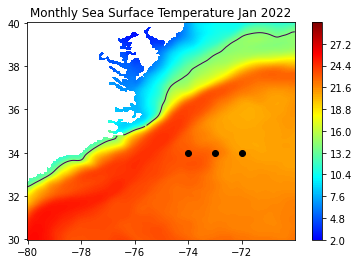

In [47]:
plt.contourf(ds.longitude, ds.latitude, ds.sea_surface_temperature[0,:,:], levs,cmap=cm)
#plot the color scale
plt.colorbar()
#example of how to add points to the map
plt.scatter(range(-74,-71),np.repeat(34,3),c='black')
#example of how to add a contour line
plt.contour(ds.longitude, ds.latitude, ds.sea_surface_temperature[0,:,:],levels=[14],linewidths=1)
#plot title
plt.title("Monthly Sea Surface Temperature " + dates[0].strftime('%b %Y'))
plt.show()

### Plotting a time series

###### Let's pick the following box : 36-38N, -77 to -75W. We are going to generate a time series of mean SST within that box.

- first, let subset our data:

**NOTE! for this product, latitudes are indexed from North to South, so this must be respected when subsetting:**

In [58]:
da=ds.sel(latitude=slice(38, 36), longitude=slice(-77,-75))

In [59]:
da.sea_surface_temperature.shape

(12, 40, 40)

- let's plot the subset:

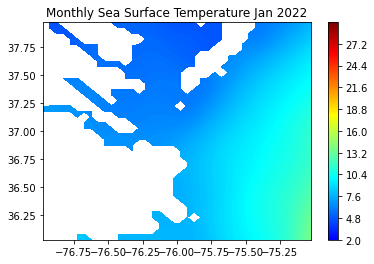

In [60]:
plt.contourf(da.longitude, da.latitude, da.sea_surface_temperature[0,:,:], levs,cmap=cm)
plt.colorbar()
plt.title("Monthly Sea Surface Temperature " + dates[0].strftime('%b %Y'))
plt.show()

- let's compute the monthly mean over the bounding region:

In [61]:
res=np.mean(da.sea_surface_temperature,axis=(1,2))

- let's plot the time-series:

Text(0, 0.5, 'SST (ºC)')

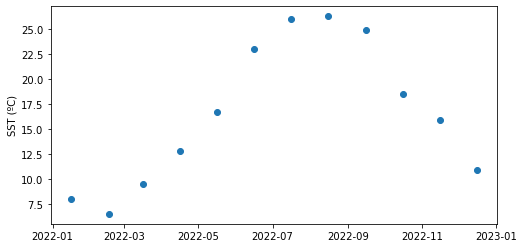

In [62]:
plt.figure(figsize=(8,4))
plt.scatter(dates,res)
plt.ylabel('SST (ºC)')

### Creating a map of average SST over a year

- let's compute the yearly mean for the region:

In [63]:
mean_sst=np.mean(ds.sea_surface_temperature,axis=0)

In [64]:
mean_sst.shape

(202, 201)

- let's plot the map of the 2022 average SST in the region:

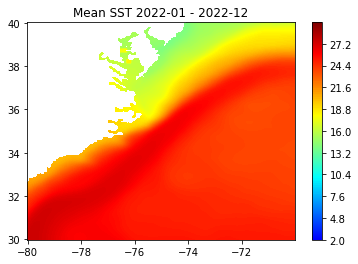

In [65]:
plt.contourf(ds.longitude, ds.latitude, mean_sst, levs,cmap=cm)
plt.colorbar()
plt.title("Mean SST " + dates[0].strftime('%Y-%m')+' - '+dates[11].strftime('%Y-%m'))
plt.show()